In [44]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
from torch import nn
from torch import flatten
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [45]:
class simple_cnn(nn.Module):
    #Made using LeNet as reference, use relu fn and maxpool
    def __init__(self, classes, numChannels=1):
		# call the parent constructor
        super(simple_cnn, self).__init__()
		# First convolution-relu-maxpool layer
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# Second convolution-relu-maxpool layer
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.relu3 = nn.ReLU()
		# initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
		# first set of CONV => RELU =>POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        #x = self.relu1(x)
		# the second set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        #x = self.relu2(x)
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# pass the output to softmax
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# return the output predictions
        return output

In [46]:
# define training hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 15
# define the train and val splits
TRAIN_SPLIT = 0.75
TEST_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [47]:
print("Loading the FashionMNIST dataset...")
trainData = FashionMNIST(root="data", train=True, download=True,transform=ToTensor())
testData = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
# calculate the train/validation split
print("Generating the train/Test split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numTestSamples = int(len(trainData) * TEST_SPLIT)
(trainData, testData) = random_split(trainData, [numTrainSamples, numTestSamples], generator=torch.Generator().manual_seed(34))

Loading the FashionMNIST dataset...
Generating the train/Test split...


In [48]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
testDataLoader = DataLoader(testData, batch_size=batch_size)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // batch_size
testSteps = len(testDataLoader.dataset) // batch_size


In [49]:
# initialize the model
print("Initializing the CNN model...")
model = simple_cnn(numChannels=1, classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=learning_rate, weight_decay=0.002)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}
# measure how long training is going to take
print("Training the network...")
startTime = time.time()


Initializing the CNN model...
Training the network...


In [50]:
# loop over our epochs
for e in range(0, epochs):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	testCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()


    
    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in testDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalTestLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    # calculate the average training and test loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# calculate the training and test accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	testCorrect = testCorrect / len(testDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	H["test_acc"].append(testCorrect)
	# print the model training and testing information
	print("EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avgTestLoss, testCorrect))
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Evaluating network...")
            

EPOCH: 1/15
Train loss: 0.596227, Train accuracy: 0.7838
Test loss: 0.439553, Test accuracy: 0.8415

EPOCH: 2/15
Train loss: 0.399142, Train accuracy: 0.8567
Test loss: 0.383232, Test accuracy: 0.8616

EPOCH: 3/15
Train loss: 0.357671, Train accuracy: 0.8715
Test loss: 0.336620, Test accuracy: 0.8800

EPOCH: 4/15
Train loss: 0.332428, Train accuracy: 0.8806
Test loss: 0.353840, Test accuracy: 0.8697

EPOCH: 5/15
Train loss: 0.315186, Train accuracy: 0.8858
Test loss: 0.335830, Test accuracy: 0.8775

EPOCH: 6/15
Train loss: 0.307948, Train accuracy: 0.8896
Test loss: 0.324906, Test accuracy: 0.8817

EPOCH: 7/15
Train loss: 0.297724, Train accuracy: 0.8925
Test loss: 0.365331, Test accuracy: 0.8623

EPOCH: 8/15
Train loss: 0.285312, Train accuracy: 0.8976
Test loss: 0.299998, Test accuracy: 0.8911

EPOCH: 9/15
Train loss: 0.282164, Train accuracy: 0.8985
Test loss: 0.299059, Test accuracy: 0.8911

EPOCH: 10/15
Train loss: 0.278140, Train accuracy: 0.8995
Test loss: 0.284704, Test accurac

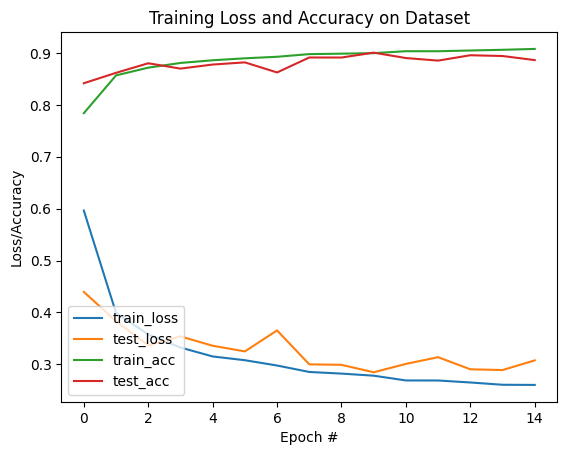

In [51]:
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["test_acc"], label="test_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# 